# Convolutional Autoencoder for MNIST

In [1]:
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations
from tensorflow.python.keras.models import Model
import os
import scipy
from tqdm import tqdm
import numpy as np
import util
from matplotlib import pyplot as plt

## Some Helper Functions

In [2]:
def show_image(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

In [3]:
def show_side_by_side(img1, img2):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.show()

## The Dataset

Loading the MNIST Dataset. Ignoring the y values, since they are not needed to train the autoencoder. 

In [4]:
from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

There are 60,000 images of numbers with values ranging from 0 to 255.

(60000, 28, 28)
255
0


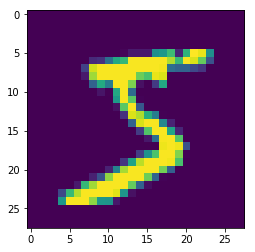

In [5]:
print(x_train.shape)
print(np.max(x_train))
print(np.min(x_train))

show_image(x_train[0])

Normalizing the dataset to values betweeen 0 and 1.

In [6]:
x_train = x_train / 255
x_test = x_test / 255

(60000, 28, 28)
1.0
0.0


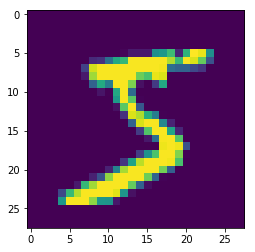

In [7]:
print(x_train.shape)
print(np.max(x_train))
print(np.min(x_train))

show_image(x_train[0])

## The Model

Defining some constants for later. Even if the memory permits it, do not use too large a BATCH_SIZE, that can decreas learning rate A LOT, probably connected to the effect obeserved here: https://arxiv.org/pdf/1609.04836.pdf.

In [8]:
LEARNING_RATE = 0.001
BATCH_SIZE = 100
EPOCHS = 100

Building the Model of the autoencoder.

In [9]:
input_layer = layers.Input(shape=(28,28))

# This reshaping has to be done, to add the channel dimension, which is used and extended by the convolutional layers
# It would also be possible to reshape the dataset beforehand
x = layers.Reshape(target_shape=(28,28,1))(input_layer)

# Encoder part of the autoencoder
# Padding "same" is needed or the ouput would not be of size 28 by 28, but smaller
# because the size of the input is not divisible by the kernal size
x = layers.Conv2D(filters=8, kernel_size=3, padding="same", activation="relu")(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x) # Shape down to (14,14,8)
x = layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu")(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x) # Shape down to (7,7,16)
x = layers.Flatten()(x) # Shape down to (784,)
x = layers.Dense(128, activation="relu", name="encoded")(x)

# Decoder part of the autoencoder
x = layers.Dense(784, activation="relu")(x)
x = layers.Reshape(target_shape=(7,7,16))(x) # "Reversing" the Flatten layer
x = layers.UpSampling2D(size=(2, 2))(x) # "Reversing" the MaxPool2D layer
x = layers.Conv2D(8, kernel_size=3, padding="same", activation="relu")(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(1, kernel_size=3, padding="same", activation="relu")(x)

# Reversing the initial reshaping of the input
output_layer =  layers.Reshape((28,28))(x)

model = Model(input_layer, output_layer)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
__________

Defining the optimizer and loss function. Using the simple stochastic gradient decent optimizer and mean squared error loss. Also using momentum for faster convergence.

In [10]:
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=0.9)
loss = keras.losses.mean_squared_error

Compiling the model.

In [11]:
model.compile(optimizer=optimizer, loss=loss)

Fitting the model to the data. The input and output data is the same, to teach the autoencoder to recover the original input.

In [12]:
history = model.fit(x=x_train, y=x_train, batch_size=BATCH_SIZE, validation_data=(x_test, x_test), epochs=EPOCHS, shuffle=True, verbose=2, )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 7s - loss: 0.0910 - val_loss: 0.0834
Epoch 2/100
 - 5s - loss: 0.0726 - val_loss: 0.0670
Epoch 3/100
 - 5s - loss: 0.0646 - val_loss: 0.0629
Epoch 4/100
 - 5s - loss: 0.0612 - val_loss: 0.0595
Epoch 5/100
 - 5s - loss: 0.0578 - val_loss: 0.0560
Epoch 6/100
 - 5s - loss: 0.0543 - val_loss: 0.0525
Epoch 7/100
 - 5s - loss: 0.0510 - val_loss: 0.0492
Epoch 8/100
 - 5s - loss: 0.0480 - val_loss: 0.0464
Epoch 9/100
 - 5s - loss: 0.0454 - val_loss: 0.0439
Epoch 10/100
 - 5s - loss: 0.0431 - val_loss: 0.0417
Epoch 11/100
 - 5s - loss: 0.0411 - val_loss: 0.0398
Epoch 12/100
 - 5s - loss: 0.0394 - val_loss: 0.0382
Epoch 13/100
 - 5s - loss: 0.0380 - val_loss: 0.0368
Epoch 14/100
 - 5s - loss: 0.0367 - val_loss: 0.0356
Epoch 15/100
 - 5s - loss: 0.0355 - val_loss: 0.0345
Epoch 16/100
 - 5s - loss: 0.0345 - val_loss: 0.0335
Epoch 17/100
 - 5s - loss: 0.0335 - val_loss: 0.0326
Epoch 18/100
 - 5s - loss: 0.0327 - val_loss: 0.0317
Epoch

## Visualizing the Results

In [13]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

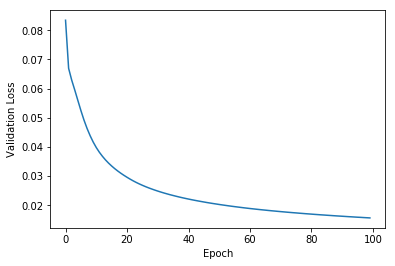

In [14]:
plt.figure()
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.show()

Using the model on the complete test set.

In [15]:
results = model.predict(x_test)

Visualizing some examples. On the left is the original image, on the right is the image recovered by the autoencoder.

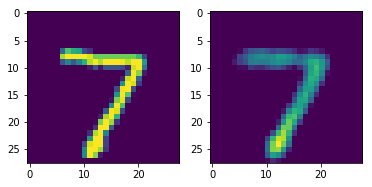

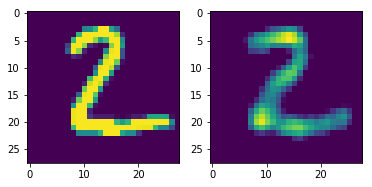

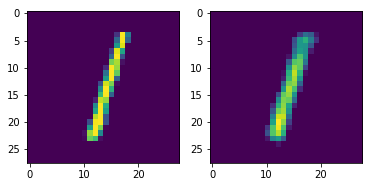

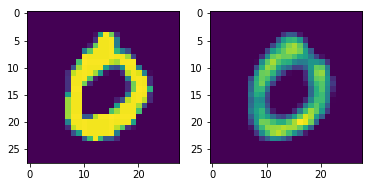

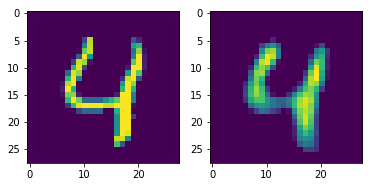

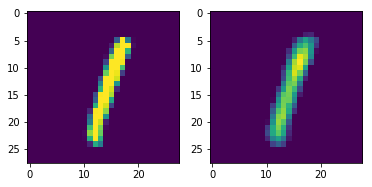

In [ ]:
for i in range(10):
    show_side_by_side(x_test[i], results[i])

## Saving the model

In [22]:
model.save('mnist_autoencoder.h5')